In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import itertools
import random
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# <br>
# 전처리

In [2]:
온라인 = pd.read_csv('01.온라인 행동 정보.csv', encoding='utf-8')
온라인 = 온라인.sort_values(['clnt_id','sess_id','hit_seq']).reset_index(drop=True)
온라인.shape

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(3196362, 14)

In [3]:
온라인['unique_id'] = list(map(lambda x,y: str(x)+'_'+str(y), 온라인.clnt_id, 온라인.sess_id))
온라인.head()

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm,unique_id
0,1,1,1,0,A01,20190911,16:14,11880,NaN,과일선물세트,14.0,124.0,unknown,mobile_app,1_1
1,1,1,2,0,A01,20190911,16:15,22432,NaN,과일선물세트 백화점,14.0,124.0,unknown,mobile_app,1_1
2,1,1,3,0,A01,20190911,16:15,36140,NaN,과일바구니,14.0,124.0,unknown,mobile_app,1_1
3,1,2,1,0,A01,20190922,14:09,41584,NaN,초등가을잠바,45.0,424.0,unknown,mobile_app,1_2
4,1,2,2,0,A01,20190922,14:10,56113,NaN,초등가을점퍼,45.0,424.0,unknown,mobile_app,1_2


In [5]:
온라인.groupby('unique_id').biz_unit.nunique().describe()

count    367149.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: biz_unit, dtype: float64

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  This is separate from the ipykernel package so we can avoid doing imports until


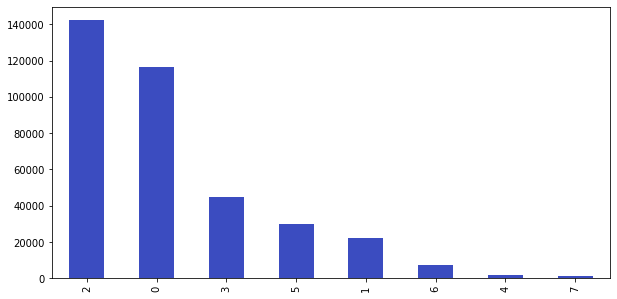

In [122]:
plt.figure(figsize=(10,5))
온라인[온라인.hit_seq == 1].action_type.value_counts().plot('bar')
plt.show()

In [4]:
# 온라인 고객: 72,399명, 고객 및 세션: 367,149개
온라인.clnt_id.nunique(), 온라인.unique_id.nunique()

(72399, 367149)

In [6]:
# 각 clnt_id별 session이 바뀌는 지점 index 저장
idx1 = 온라인.unique_id.drop_duplicates().index.tolist()
idx2 = idx1[1:] + [len(온라인)]

In [7]:
# session별 체류시간 = 다음 hit_pss_tm - 이전 hit_pss_tm
stay_tm = []
for i, j in tqdm_notebook(zip(idx1, idx2), total=len(idx1)):
    temp = 온라인.iloc[i:j].hit_pss_tm
    if len(temp) == 1:
        stay_tm.append(temp.tolist())
    else:
        temp = temp.diff().tolist()[1:]
        temp.append(temp[-1]) # 마지막은 해당 hit_pss_tm 값 사용
        stay_tm.append(temp)
    #stay_tm = stay_tm + 온라인.iloc[i:j].hit_pss_tm.diff().fillna(0).tolist()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
#stay_tm = sum(stay_tm, []) # 시간 매우 오래걸림
온라인['time_length'] = list(itertools.chain.from_iterable(stay_tm))

In [9]:
# 밀리초->초 변환
온라인['hit_pss_tm'] = np.ceil(온라인['hit_pss_tm']/1000)
온라인['time_length'] = np.ceil(온라인['time_length']/1000)

In [10]:
# 주말 및 공휴일 여부
holiday_diff = []
for i in 온라인.sess_dt.map(lambda x: str(x)[-3:]).tolist():
    if i in (['706','707','713','714','717','720','721','727','728',
               '803','804','810','811','815','817','818','824','825',
               '907','908','912','913','914','915','921','922','928','929']):
        holiday_diff.append(1)
    else:
        holiday_diff.append(0)
온라인['holiday_diff'] = holiday_diff

In [11]:
# keyword: session별 sech_kwd의 cumulative sum
온라인['sech_kwd'] = 온라인.sech_kwd.map(lambda x: 0 if str(x) == 'nan' else 1)
keyword = []
for i, j in tqdm_notebook(zip(idx1, idx2), total=len(idx1)):
    temp = 온라인.iloc[i:j].sech_kwd
    keyword.append(np.cumsum(temp.tolist()))
온라인['keyword'] = list(itertools.chain.from_iterable(keyword))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [12]:
온라인['sess_dt'] = 온라인['sess_dt'].map(lambda x: str(x)[:-2]) # day제거하고 month(7,8,9월)만 남김
온라인['dvc_ctg_nm'].fillna('unknown',inplace=True) # device null값을 unknown으로 대체

# dummy variable 생성 - action_type, biz_unit, sess_dt, trfc_src, dvc_ctg_nm
온라인 = pd.concat([온라인, pd.get_dummies(온라인[['biz_unit','sess_dt','trfc_src','dvc_ctg_nm']])], axis=1) # sensitivy analysis 위해서 drop_first=False 사용
온라인 = pd.concat([온라인, pd.get_dummies(온라인.action_type, prefix='action_type')], axis=1) # drop_fist=False
온라인 = 온라인.drop(['action_type','biz_unit','sess_dt','hit_tm','sech_kwd','tot_pag_view_ct', 'tot_sess_hr_v','trfc_src','dvc_ctg_nm'], axis=1)

In [13]:
온라인 = 온라인[['clnt_id', 'sess_id', 'trans_id', 'hit_seq', 'hit_pss_tm', 'time_length', 'holiday_diff', 'keyword',
                'action_type_0', 'action_type_1', 'action_type_2', 'action_type_3','action_type_4', 'action_type_5', 'action_type_6', 'action_type_7',
                'biz_unit_A01', 'biz_unit_A02', 'biz_unit_A03', 'sess_dt_201907', 'sess_dt_201908', 'sess_dt_201909', 
                'trfc_src_DIRECT', 'trfc_src_PORTAL_1', 'trfc_src_PORTAL_2', 'trfc_src_PORTAL_3', 'trfc_src_PUSH', 'trfc_src_WEBSITE', 'trfc_src_unknown', 
                'dvc_ctg_nm_PC', 'dvc_ctg_nm_mobile_app','dvc_ctg_nm_mobile_web', 'dvc_ctg_nm_unknown', 'unique_id']]

In [14]:
# 각 hit_seq 당 action_type이 구매완료=1, 이외=0
온라인['buy'] = 온라인['action_type_6']
온라인 = 온라인.drop(['action_type_5', 'action_type_6', 'action_type_7'], axis=1)
print(온라인.shape)
온라인.head()

(3196362, 32)


,clnt_id,sess_id,trans_id,hit_seq,hit_pss_tm,time_length,holiday_diff,keyword,action_type_0,action_type_1,...,trfc_src_PORTAL_3,trfc_src_PUSH,trfc_src_WEBSITE,trfc_src_unknown,dvc_ctg_nm_PC,dvc_ctg_nm_mobile_app,dvc_ctg_nm_mobile_web,dvc_ctg_nm_unknown,unique_id,buy
0,1,1,NaN,1,12.0,11.0,0,1,1,0,...,0,0,0,1,0,1,0,0,1_1,0
1,1,1,NaN,2,23.0,14.0,0,2,1,0,...,0,0,0,1,0,1,0,0,1_1,0
2,1,1,NaN,3,37.0,14.0,0,3,1,0,...,0,0,0,1,0,1,0,0,1_1,0
3,1,2,NaN,1,42.0,15.0,1,1,1,0,...,0,0,0,1,0,1,0,0,1_2,0
4,1,2,NaN,2,57.0,14.0,1,2,1,0,...,0,0,0,1,0,1,0,0,1_2,0


In [15]:
온라인.columns

Index(['clnt_id', 'sess_id', 'trans_id', 'hit_seq', 'hit_pss_tm',
       'time_length', 'holiday_diff', 'keyword', 'action_type_0',
       'action_type_1', 'action_type_2', 'action_type_3', 'action_type_4',
       'biz_unit_A01', 'biz_unit_A02', 'biz_unit_A03', 'sess_dt_201907',
       'sess_dt_201908', 'sess_dt_201909', 'trfc_src_DIRECT',
       'trfc_src_PORTAL_1', 'trfc_src_PORTAL_2', 'trfc_src_PORTAL_3',
       'trfc_src_PUSH', 'trfc_src_WEBSITE', 'trfc_src_unknown',
       'dvc_ctg_nm_PC', 'dvc_ctg_nm_mobile_app', 'dvc_ctg_nm_mobile_web',
       'dvc_ctg_nm_unknown', 'unique_id', 'buy'],
      dtype='object')

In [16]:
len(온라인.columns)

32

In [24]:
# 저장하고 가자
온라인.to_csv('온라인_전처리_final_32columns.csv', index=False)

In [3]:
온라인 = pd.read_csv('온라인_전처리_final_32columns.csv')
print(온라인.shape)
온라인.head()

(3196362, 32)


,clnt_id,sess_id,trans_id,hit_seq,hit_pss_tm,time_length,holiday_diff,keyword,action_type_0,action_type_1,...,trfc_src_PORTAL_3,trfc_src_PUSH,trfc_src_WEBSITE,trfc_src_unknown,dvc_ctg_nm_PC,dvc_ctg_nm_mobile_app,dvc_ctg_nm_mobile_web,dvc_ctg_nm_unknown,unique_id,buy
0,1,1,NaN,1,12.0,11.0,0,1,1,0,...,0,0,0,1,0,1,0,0,1_1,0
1,1,1,NaN,2,23.0,14.0,0,2,1,0,...,0,0,0,1,0,1,0,0,1_1,0
2,1,1,NaN,3,37.0,14.0,0,3,1,0,...,0,0,0,1,0,1,0,0,1_1,0
3,1,2,NaN,1,42.0,15.0,1,1,1,0,...,0,0,0,1,0,1,0,0,1_2,0
4,1,2,NaN,2,57.0,14.0,1,2,1,0,...,0,0,0,1,0,1,0,0,1_2,0


# <br>
# 모델링

In [17]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D
from keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.layers.embeddings import Embedding
from keras.layers import Dropout
from keras.layers import Masking
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.over_sampling import RandomOverSampler
from keras.utils import to_categorical

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0

In [18]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [19]:
def make_padding_and_oversample(X, Y, length=70):
    max_len = length #np.percentile(pd.Series(idx),99)
    X_padding = sequence.pad_sequences(X, maxlen=max_len, padding='pre', truncating='post')
    X_padding2 = X_padding.reshape(X.shape[0], max_len* X_padding.shape[2])

    smote = SMOTE(random_state=0)
    X_resampled, Y_resampled = smote.fit_resample(X_padding2, Y)
    X_resampled = X_resampled.reshape(X_resampled.shape[0], max_len, X_padding.shape[2])
    return X_padding, X_resampled, Y_resampled

## 각 session의 첫번째 구매완료까지 data만 사용

In [20]:
# 고객별 세션당 구매 횟수: 0~25까지 다양함
# 우선 첫번째 구매를 기준으로 자름
온라인.groupby('unique_id').buy.sum().value_counts()

0     319742
1      40869
2       5104
3       1007
4        262
5         86
6         38
7         10
8          6
10         6
9          4
11         4
12         3
17         3
21         2
15         1
18         1
25         1
Name: buy, dtype: int64

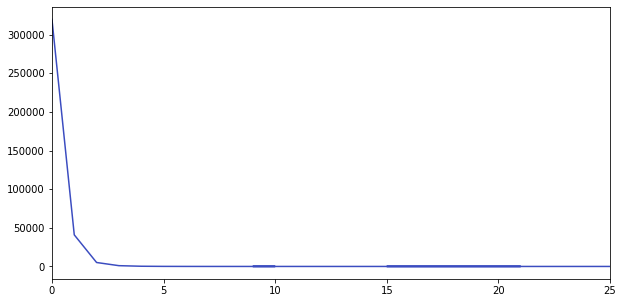

In [157]:
plt.figure(figsize=(10,5))
온라인.groupby('unique_id').buy.sum().value_counts().plot()

In [21]:
# 각 clnt_id별 session이 바뀌는 지점 index 저장
idx1 = 온라인.unique_id.drop_duplicates().index.tolist()
idx2 = idx1[1:] + [len(온라인)]

In [22]:
# 구매 시점이 있으면 index 저장하고 없으면 마지막 index 그대로 가져옴
idx3 = []
for i, j in tqdm_notebook(zip(idx1, idx2), total=len(idx1)):
    temp = 온라인.buy.iloc[i:j]
    try:
        idx3.append(temp[temp == 1].index[0])
    except:
        idx3.append(j)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
idx = list(pd.Series(idx3) - pd.Series(idx1))
pd.Series(idx).describe()

count    367149.000000
mean          8.253755
std          14.284735
min           0.000000
25%           1.000000
50%           3.000000
75%           8.000000
max         357.000000
dtype: float64

In [23]:
# (session, sequence, variables) 3d array 변환
온라인_x = []
for i, j in tqdm_notebook(zip(idx1, idx3), total=len(idx1)):
    온라인_x.append(온라인.iloc[i:j, 3:-2].values)
    
#scaler = StandardScaler() 
#scaler = MinMaxScaler(feature_range=(0, 1))
#온라인_x = scaler.fit_transform(np.array(온라인_x))
온라인_x = np.array(온라인_x)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
# session 당 구매 여부 (label값)
온라인_y = []
for i,j in tqdm_notebook(zip(idx1,idx2), total=len(idx1)):
    온라인_y.append([int(온라인.buy.iloc[i:j].sum()>0)])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
# 구매완료한 session이 전체의 약 13%
pd.Series(온라인_y).value_counts()*100/온라인.unique_id.nunique()

[0]    87.087804
[1]    12.912196
dtype: float64

In [25]:
pd.Series(온라인_y).value_counts()

[0]    319742
[1]     47407
dtype: int64

In [26]:
# model layer
def models(train):
    model = Sequential()
    model.add(Masking(mask_value=0., input_shape=(train.shape[1], train.shape[2])))
    model.add(LSTM(64,input_shape = (train.shape[1], train.shape[2])))
    model.add(Dense(32, activation= 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation= 'relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr= 0.001, rho = 0.9), metrics=['acc',f1_m,precision_m, recall_m])
    return model

## hit_seq별 accuray

In [158]:
history1, history2, accuracy_list, f1_list, precision_list, recall_list = [], [], [], [], [], []
for hitseq_num in tqdm_notebook(range(1,11)):
    X_padded, X_resampled, Y_resampled = make_padding_and_oversample(np.array(온라인_x), 온라인_y, length= int(hitseq_num))
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, Y_resampled, test_size=0.3, random_state=42)
    
    model = models(X_train)
    history = model.fit(X_train, y_train, epochs=25, batch_size=1000, validation_data=(X_test, y_test), verbose=0, shuffle=True)
    loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=0)
    print(hitseq_num, np.round(accuracy, 3))

    history1.append(list(history.history['acc']))
    history2.append(list(history.history['val_acc']))
    accuracy_list.append(accuracy)
    f1_list.append(f1_score)
    precision_list.append(precision)
    recall_list.append(recall)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


1 0.851


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


2 0.91


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


3 0.929


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


4 0.926


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


5 0.943


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


6 0.945


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


7 0.947


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


8 0.95


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


9 0.953


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


10 0.952



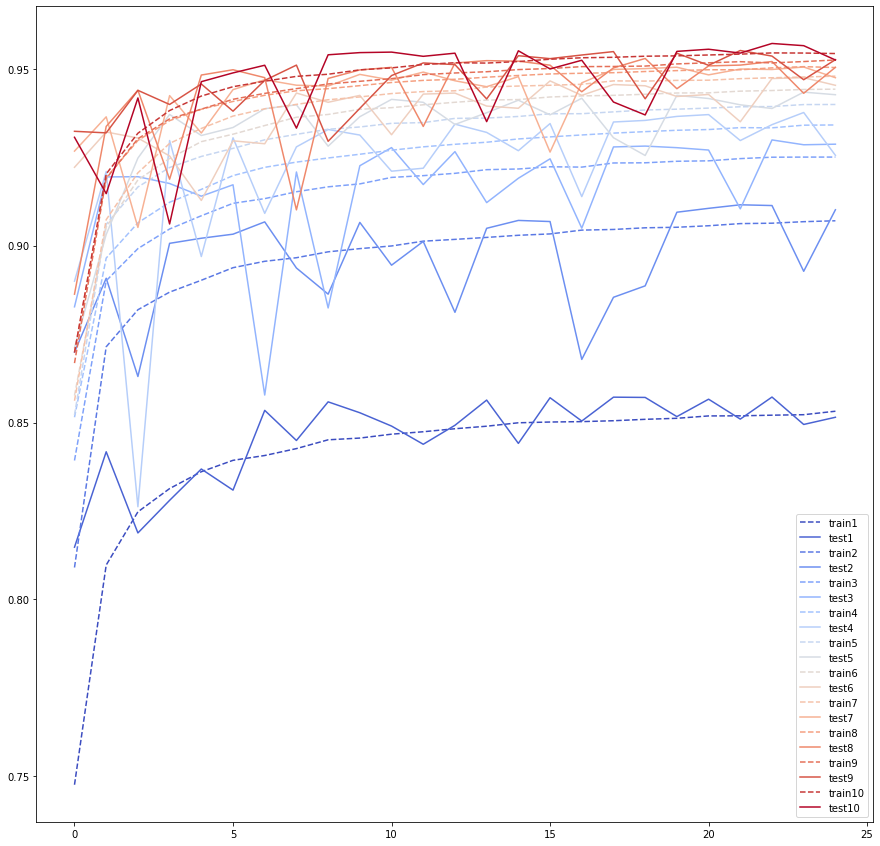

In [159]:
# plot history
from matplotlib import rcParams, cycler
plt.figure(figsize=(15,15))
cmap = plt.cm.coolwarm
rcParams['axes.prop_cycle'] = cycler(color=cmap(np.linspace(0, 1, 20)))

for i, tr, val in zip(range(1,11), history1, history2):
    plt.plot(tr, '--', label='train{}'.format(i))
    plt.plot(val, label='test{}'.format(i))
plt.legend()                                       
plt.show()    

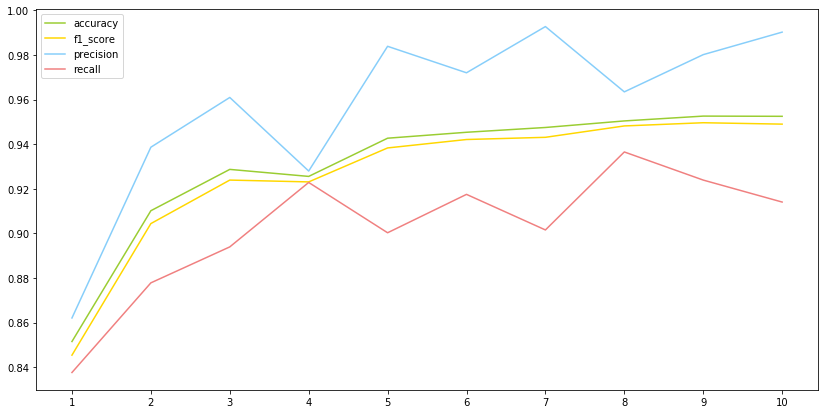

In [164]:
# plot history
plt.figure(figsize=(14,7))
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
plt.plot(accuracy_list, label='accuracy', color= colors[0])
plt.plot(f1_list, label='f1_score', color= colors[1])
plt.plot(precision_list, label='precision', color= colors[2])
plt.plot(recall_list, label='recall', color= colors[3])
plt.xticks(range(10), range(1,11))
plt.legend()                                       
plt.show()

In [163]:
pd.DataFrame({'accuracy': accuracy_list,
              'f1_score': f1_list,
              'precision': precision_list,
              'recall': recall_list}, index= pd.Series(range(1,11)).map(lambda x: 'hitseq ' +str(x)))

,accuracy,f1_score,precision,recall
hitseq 1,0.851490,0.845378,0.862052,0.837595
hitseq 2,0.910141,0.904369,0.938624,0.877797
hitseq 3,0.928677,0.923884,0.960931,0.893923
hitseq 4,0.925529,0.923063,0.927937,0.922821
hitseq 5,0.942662,0.938296,0.983871,0.900259
hitseq 6,0.945321,0.942075,0.971999,0.917474
hitseq 7,0.947468,0.943060,0.992718,0.901522
hitseq 8,0.950408,0.948160,0.963440,0.936493
hitseq 9,0.952571,0.949598,0.980132,0.923886
hitseq 10,0.952478,0.948972,0.990225,0.914027


In [16]:
history1, history2, accuracy_list, f1_list, precision_list, recall_list = [], [], [], [], [], []
for hitseq_num in tqdm_notebook(range(1,10)):
    X_padded, X_resampled, Y_resampled = make_padding_and_oversample(np.array(온라인_x), 온라인_y, length= int(hitseq_num))
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, Y_resampled, test_size=0.3, random_state=42)
    
    model = models(X_train)
    history = model.fit(X_train, y_train, epochs=25, batch_size=1000, validation_data=(X_test, y_test), verbose=0, shuffle=True)
    loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=0)
    print(hitseq_num, np.round(accuracy, 3))

    history1.append(list(history.history['acc']))
    history2.append(list(history.history['val_acc']))
    accuracy_list.append(accuracy)
    f1_list.append(f1_score)
    precision_list.append(precision)
    recall_list.append(recall)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

191846/191846 [==============================] - 16s 83us/step
3196360 0.858


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


191846/191846 [==============================] - 20s 102us/step
3196360 0.911


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


191846/191846 [==============================] - 23s 118us/step
3196360 0.93


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


191846/191846 [==============================] - 26s 135us/step
3196360 0.938


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


191846/191846 [==============================] - 29s 150us/step
3196360 0.94


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


191846/191846 [==============================] - 32s 169us/step
3196360 0.945


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


191846/191846 [==============================] - 36s 187us/step
3196360 0.949


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


191846/191846 [==============================] - 39s 205us/step
3196360 0.943


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


191846/191846 [==============================] - 43s 223us/step
3196360 0.954



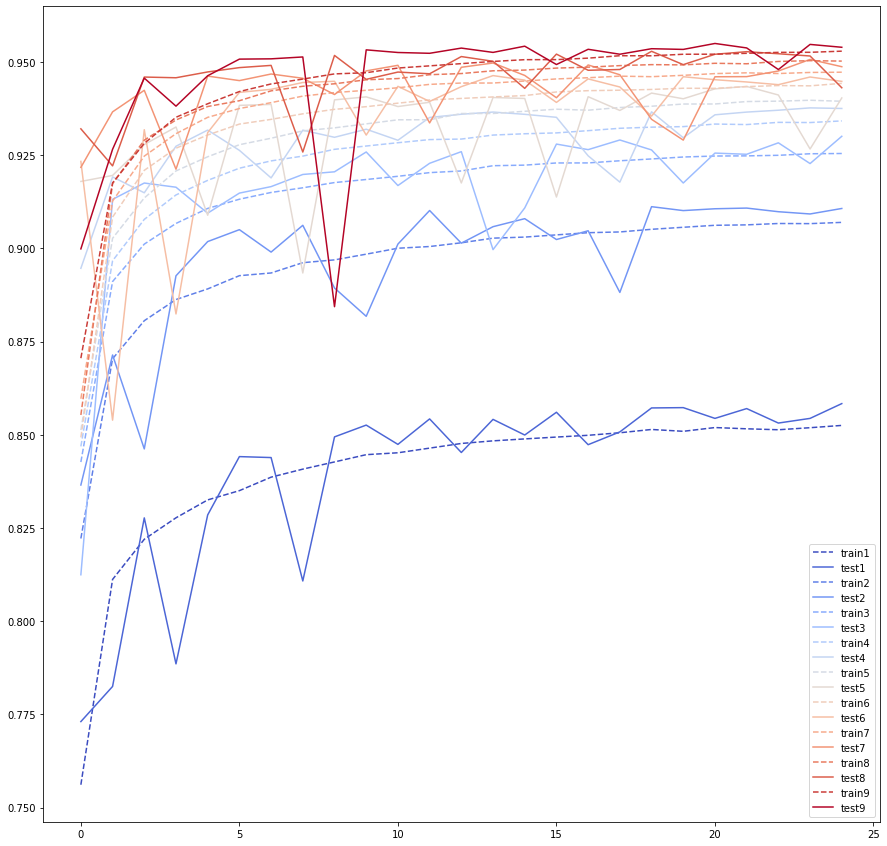

In [37]:
# plot history
from matplotlib import rcParams, cycler
plt.figure(figsize=(15,15))
cmap = plt.cm.coolwarm
rcParams['axes.prop_cycle'] = cycler(color=cmap(np.linspace(0, 1, 18)))

for i, tr, val in zip(range(1,10), history1, history2):
    plt.plot(tr, '--', label='train{}'.format(i))
    plt.plot(val, label='test{}'.format(i))
plt.legend()                                       
plt.show()    

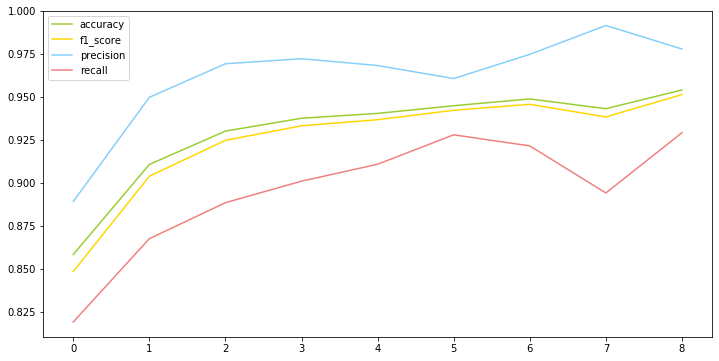

In [55]:
# plot history
plt.figure(figsize=(12,6))
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
plt.plot(accuracy_list, label='accuracy', color= colors[0])
plt.plot(f1_list, label='f1_score', color= colors[1])
plt.plot(precision_list, label='precision', color= colors[2])
plt.plot(recall_list, label='recall', color= colors[3])
plt.legend()                                       
plt.show()

In [62]:
pd.DataFrame({'accuracy': accuracy_list,
              'f1_score': f1_list,
              'precision': precision_list,
              'recall': recall_list}, index= pd.Series(range(1,10)).map(lambda x: 'hitseq ' +str(x)))

,accuracy,f1_score,precision,recall
hitseq 1,0.858381,0.848496,0.889209,0.819194
hitseq 2,0.910736,0.903894,0.949727,0.867600
hitseq 3,0.930100,0.924746,0.969229,0.888499
hitseq 4,0.937564,0.933167,0.972140,0.901007
hitseq 5,0.940384,0.936723,0.968194,0.910838
hitseq 6,0.944836,0.942204,0.960603,0.927932
hitseq 7,0.948771,0.945662,0.974697,0.921493
hitseq 8,0.943121,0.938337,0.991467,0.894127
hitseq 9,0.953984,0.951317,0.977793,0.929186


In [63]:
## Sensitivity Analysis
full_X_c = 온라인.iloc[:,3:-2].columns
a_features = int(X_train.shape[2])
importance_df = pd.DataFrame(np.zeros((a_features, 2)), 
                             columns=['varible_name', 'perturbation_effect'])
a_features, len(full_X_c)

(27, 27)

In [78]:
def var_importance(model):
    orig_out = model.predict(X_test)
    for i in tqdm_notebook(range(a_features)):  # iterate over the three features
        new_x = X_test.copy()
        new_x[:, :, i] = new_x[:, :, i] * 0
        perturbed_out = model.predict(new_x)
        effect = ((orig_out - perturbed_out) ** 2).mean() ** 0.5 #RMSE
        importance_df.iloc[i,0] = full_X_c[i]
        importance_df.iloc[i,1] = effect
        #print(f'Variable {i+1}, perturbation effect: {effect:.4f}')
var_importance(model)
importance_df = importance_df.sort_values(by='perturbation_effect', ascending=False)
importance_df

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


,varible_name,perturbation_effect
1,hit_pss_tm,0.558685
2,time_length,0.318462
0,hit_seq,0.180771
13,sess_dt_201907,0.161664
14,sess_dt_201908,0.158715
15,sess_dt_201909,0.155674
5,action_type_0,0.140144
7,action_type_2,0.131012
26,dvc_ctg_nm_unknown,0.124541
16,trfc_src_DIRECT,0.123873


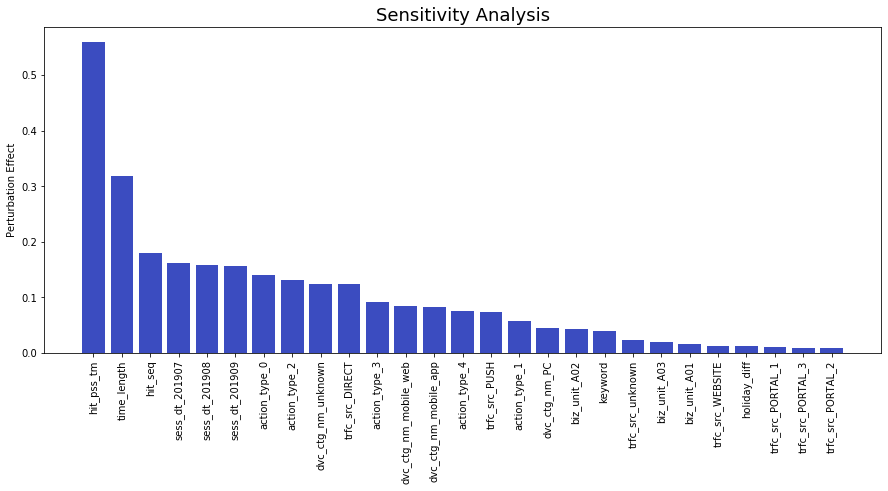

In [83]:
## Plot 예시
plt.subplots(figsize=(15,6))
plt.bar(importance_df.iloc[:,0], importance_df.iloc[:,1])
plt.title('Sensitivity Analysis', fontsize=18)
plt.ylabel('Perturbation Effect')
plt.xticks(importance_df.iloc[:,0], rotation=90)
plt.show()

In [125]:
len(idx), len(온라인_x), len(온라인_y)

(367149, 367149, 367149)

In [136]:
history1, history2, accuracy_list, f1_list, precision_list, recall_list = [], [], [], [], [], []
arr_len = [len(온라인_x)]
for hitseq_num in tqdm_notebook(range(1,11)):
    온라인_x1, 온라인_y1 = [], []
    for i,j,k in zip(idx, 온라인_x, 온라인_y):
        if i >= hitseq_num:
            온라인_x1.append(j)
            온라인_y1.append(k)
    arr_len.append(len(온라인_x1))
    
    X_padded, X_resampled, Y_resampled = make_padding_and_oversample(np.array(온라인_x1), 온라인_y1, length= int(hitseq_num))
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, Y_resampled, test_size=0.3, random_state=42)
    
    model = models(X_train)
    history = model.fit(X_train, y_train, epochs=25, batch_size=1000, validation_data=(X_test, y_test), verbose=0, shuffle=True)
    loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=0)
    print(hitseq_num, np.round(accuracy, 3))

    history1.append(list(history.history['acc']))
    history2.append(list(history.history['val_acc']))
    accuracy_list.append(accuracy)
    f1_list.append(f1_score)
    precision_list.append(precision)
    recall_list.append(recall)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


1 0.848


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


2 0.863


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


3 0.863


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


4 0.858


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


5 0.839


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


6 0.836


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


7 0.817


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


8 0.808


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


9 0.795


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


10 0.776



In [37]:
pd.DataFrame(arr_len, index=['hitseq'+str(i) for i in range(11)], columns=['data 수']).T

,hitseq0,hitseq1,hitseq2,hitseq3,hitseq4,hitseq5,hitseq6,hitseq7,hitseq8,hitseq9,hitseq10
data 수,367149,359779,243568,195681,163991,139324,122676,109419,98630,90094,82813


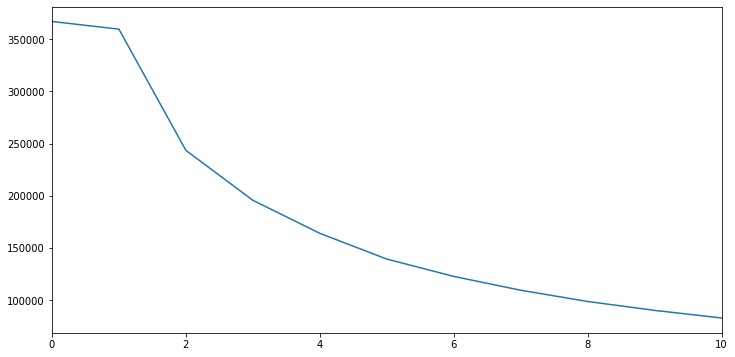

In [29]:
plt.figure(figsize=(12,6))
pd.Series(arr_len).plot()
plt.show()

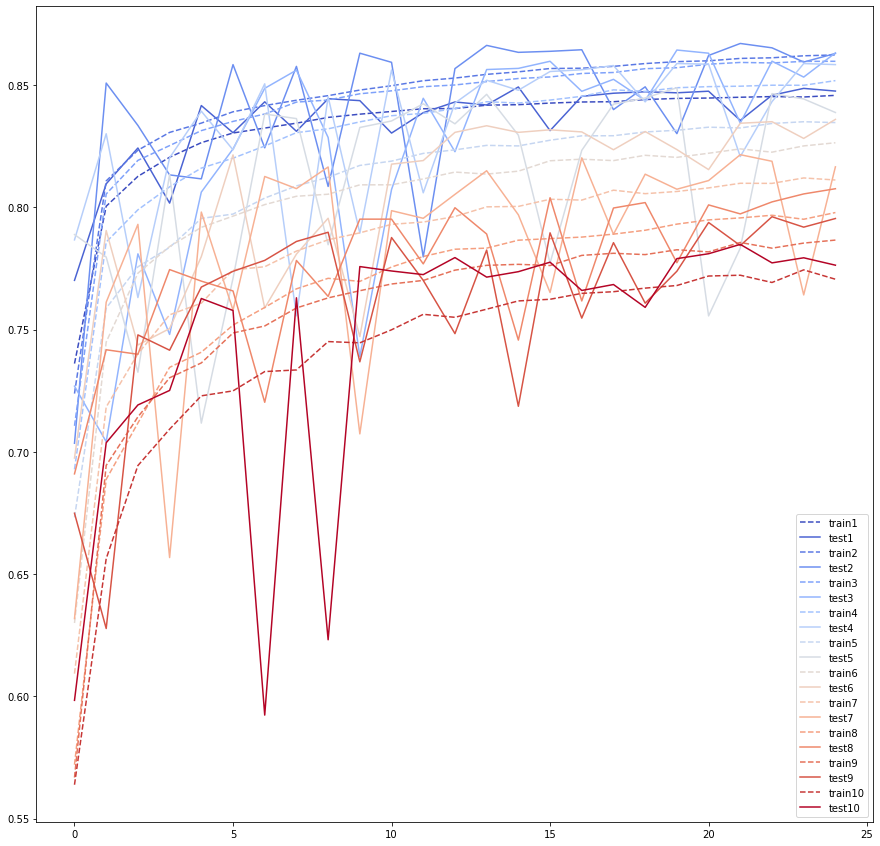

In [138]:
# plot history
from matplotlib import rcParams, cycler
plt.figure(figsize=(15,15))
cmap = plt.cm.coolwarm
rcParams['axes.prop_cycle'] = cycler(color=cmap(np.linspace(0, 1, 20)))

for i, tr, val in zip(range(1,11), history1, history2):
    plt.plot(tr, '--', label='train{}'.format(i))
    plt.plot(val, label='test{}'.format(i))
plt.legend()                                       
plt.show()    

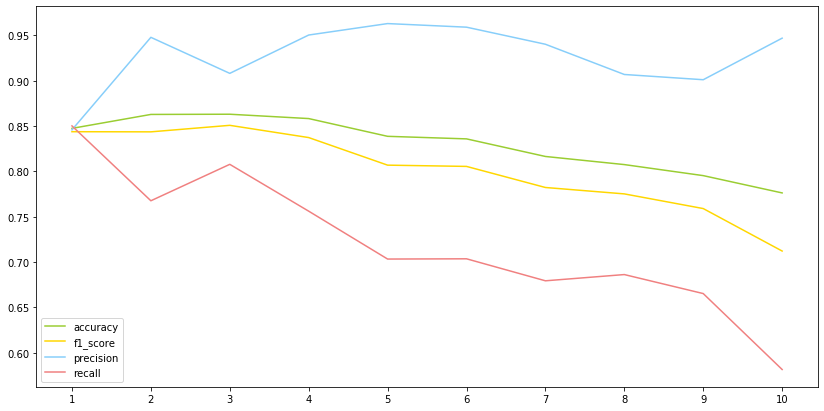

In [143]:
# plot history
plt.figure(figsize=(14,7))
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
plt.plot(accuracy_list, label='accuracy', color= colors[0])
plt.plot(f1_list, label='f1_score', color= colors[1])
plt.plot(precision_list, label='precision', color= colors[2])
plt.plot(recall_list, label='recall', color= colors[3])
plt.xticks(range(10), range(1,11))
plt.legend()                                       
plt.show()

In [141]:
pd.DataFrame({'accuracy': accuracy_list,
              'f1_score': f1_list,
              'precision': precision_list,
              'recall': recall_list}, index= pd.Series(range(1,11)).map(lambda x: 'hitseq ' +str(x)))

,accuracy,f1_score,precision,recall
hitseq 1,0.847518,0.843846,0.845899,0.850257
hitseq 2,0.862900,0.843692,0.947964,0.767657
hitseq 3,0.863131,0.850879,0.908208,0.807849
hitseq 4,0.858343,0.837386,0.950502,0.756183
hitseq 5,0.838756,0.806953,0.963136,0.703362
hitseq 6,0.835939,0.805562,0.959167,0.703633
hitseq 7,0.816530,0.782305,0.940327,0.679360
hitseq 8,0.807576,0.775243,0.906978,0.686240
hitseq 9,0.795398,0.759062,0.901192,0.665284
hitseq 10,0.776306,0.712195,0.947051,0.581506
